# A Tour of Spark’s Toolset

In Chapter 2, we introduced Spark’s core concepts, like transformations and actions, in the
context of Spark’s Structured APIs. These simple conceptual building blocks are the foundation
of Apache Spark’s vast ecosystem of tools and libraries (Figure 3-1). Spark is composed of these
primitives—the lower-level APIs and the Structured APIs—and then a series of standard
libraries for additional functionality.
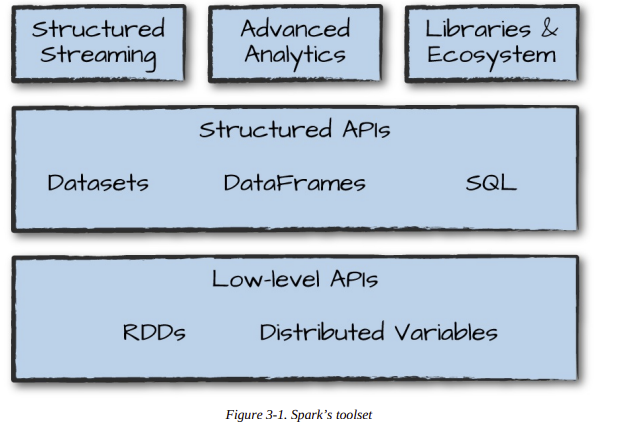
Spark’s libraries support a variety of different tasks, from graph analysis and machine learning to
streaming and integrations with a host of computing and storage systems. This chapter presents a
whirlwind tour of much of what Spark has to offer, including some of the APIs we have not yet
covered and a few of the main libraries. For each section, you will find more detailed
information in other parts of this book; our purpose here is provide you with an overview of
what’s possible.

This chapter covers the following:
* Running production applications with spark-submit
* Datasets: type-safe APIs for structured data
* Structured Streaming
* Machine learning and advanced analytics
* Resilient Distributed Datasets (RDD): Spark’s low level APIs
* SparkR
* The third-party package ecosystem

After you’ve taken the tour, you’ll be able to jump to the corresponding parts of the book to find
answers to your questions about particular topics.

## Running Production Applications
Spark makes it easy to develop and create big data programs. Spark also makes it easy to turn
your interactive exploration into production applications with spark-submit, a built-in
command-line tool. spark-submit does one thing: it lets you send your application code to a
cluster and launch it to execute there. Upon submission, the application will run until it exits
(completes the task) or encounters an error. You can do this with all of Spark’s support cluster
managers including Standalone, Mesos, and YARN.

spark-submit offers several controls with which you can specify the resources your application
needs as well as how it should be run and its command-line arguments.

You can write applications in any of Spark’s supported languages and then submit them for
execution. The simplest example is running an application on your local machine. We’ll show
this by running a sample Scala application that comes with Spark, using the following command
in the directory where you downloaded Spark:
~~~
./bin/spark-submit \
--class org.apache.spark.examples.SparkPi \
--master local \
./examples/jars/spark-examples_2.11-2.2.0.jar 10
~~~
This sample application calculates the digits of pi to a certain level of estimation. Here, we’ve
told spark-submit that we want to run on our local machine, which class and which JAR we
would like to run, and some command-line arguments for that class.

We can also run a Python version of the application using the following command:
~~~
./bin/spark-submit \
--master local \
./examples/src/main/python/pi.py 10
~~~
By changing the master argument of spark-submit, we can also submit the same application to
a cluster running Spark’s standalone cluster manager, Mesos or YARN.

spark-submit will come in handy to run many of the examples we’ve packaged with this book.
In the rest of this chapter, we’ll go through examples of some APIs that we haven’t yet seen in
our introduction to Spark.

## Datasets: Type-Safe Structured APIs
The first API we’ll describe is a type-safe version of Spark’s structured API called Datasets, for
writing statically typed code in Java and Scala. The Dataset API is not available in Python and R,
because those languages are dynamically typed.

Recall that DataFrames, which we saw in the previous chapter, are a distributed collection of
objects of type Row that can hold various types of tabular data. The Dataset API gives users the
ability to assign a Java/Scala class to the records within a DataFrame and manipulate it as a
collection of typed objects, similar to a Java ArrayList or Scala Seq. The APIs available on
Datasets are type-safe, meaning that you cannot accidentally view the objects in a Dataset as
being of another class than the class you put in initially. This makes Datasets especially attractive
for writing large applications, with which multiple software engineers must interact through
well-defined interfaces.

The Dataset class is parameterized with the type of object contained inside: Dataset<T> in Java
and Dataset[T] in Scala. For example, a Dataset[Person] will be guaranteed to contain
objects of class Person. As of Spark 2.0, the supported types are classes following the JavaBean
pattern in Java and case classes in Scala. These types are restricted because Spark needs to be
able to automatically analyze the type T and create an appropriate schema for the tabular data
within your Dataset.
    
One great thing about Datasets is that you can use them only when you need or want to. For
instance, in the following example, we’ll define our own data type and manipulate it via arbitrary
map and filter functions. After we’ve performed our manipulations, Spark can automatically turn
it back into a DataFrame, and we can manipulate it further by using the hundreds of functions
that Spark includes. This makes it easy to drop down to lower level, perform type-safe coding
when necessary, and move higher up to SQL for more rapid analysis. Here is a small example
showing how you can use both type-safe functions and DataFrame-like SQL expressions to
quickly write business logic:
~~~
// in Scala
case class Flight(DEST_COUNTRY_NAME: String,
ORIGIN_COUNTRY_NAME: String,
count: BigInt)
val flightsDF = spark.read
.parquet("/data/flight-data/parquet/2010-summary.parquet/")
val flights = flightsDF.as[Flight]
~~~
One final advantage is that when you call collect or take on a Dataset, it will collect objects of
the proper type in your Dataset, not DataFrame Rows. This makes it easy to get type safety and
securely perform manipulation in a distributed and a local manner without code changes:
~~~
// in Scala
flights
.filter(flight_row => flight_row.ORIGIN_COUNTRY_NAME != "Canada")
.map(flight_row => flight_row)
.take(5)
flights
.take(5)
.filter(flight_row => flight_row.ORIGIN_COUNTRY_NAME != "Canada")
.map(fr => Flight(fr.DEST_COUNTRY_NAME, fr.ORIGIN_COUNTRY_NAME, fr.count + 5))
~~~
We cover Datasets in depth in Chapter 11

## Structured Streaming
Structured Streaming is a high-level API for stream processing that became production-ready in
Spark 2.2. With Structured Streaming, you can take the same operations that you perform in
batch mode using Spark’s structured APIs and run them in a streaming fashion. This can reduce
latency and allow for incremental processing. The best thing about Structured Streaming is that it
allows you to rapidly and quickly extract value out of streaming systems with virtually no code
changes. It also makes it easy to conceptualize because you can write your batch job as a way to
prototype it and then you can convert it to a streaming job. The way all of this works is by
incrementally processing that data.

Let’s walk through a simple example of how easy it is to get started with Structured Streaming.
For this, we will use a retail dataset, one that has specific dates and times for us to be able to use.
We will use the “by-day” set of files, in which one file represents one day of data.

We put it in this format to simulate data being produced in a consistent and regular manner by a
different process. This is retail data so imagine that these are being produced by retail stores and
sent to a location where they will be read by our Structured Streaming job.

It’s also worth sharing a sample of the data so you can reference what the data looks like:
~~~
InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17...
536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kin...
536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850...
~~~
To ground this, let’s first analyze the data as a static dataset and create a DataFrame to do so.

We’ll also create a schema from this static dataset (there are ways of using schema inference
with streaming that we will touch on in Part V):
~~~
// in Scala
val staticDataFrame = spark.read.format("csv")
.option("header", "true")
.option("inferSchema", "true")
.load("/data/retail-data/by-day/*.csv")
staticDataFrame.createOrReplaceTempView("retail_data")
val staticSchema = staticDataFrame.schema
# in Python
staticDataFrame = spark.read.format("csv")\
.option("header", "true")\
.option("inferSchema", "true")\
.load("/data/retail-data/by-day/*.csv")
staticDataFrame.createOrReplaceTempView("retail_data")
staticSchema = staticDataFrame.schema
~~~
Because we’re working with time–series data, it’s worth mentioning how we might go along
grouping and aggregating our data. In this example we’ll take a look at the sale hours during
which a given customer (identified by CustomerId) makes a large purchase. For example, let’s
add a total cost column and see on what days a customer spent the most.

The window function will include all data from each day in the aggregation. It’s simply a
window over the time–series column in our data. This is a helpful tool for manipulating date and
timestamps because we can specify our requirements in a more human form (via intervals), and
Spark will group all of them together for us:
~~~
// in Scala
import org.apache.spark.sql.functions.{window, column, desc, col}
staticDataFrame
.selectExpr(
"CustomerId",
"(UnitPrice * Quantity) as total_cost",
"InvoiceDate")
.groupBy(
col("CustomerId"), window(col("InvoiceDate"), "1 day"))
.sum("total_cost")
.show(5)
# in Python
from pyspark.sql.functions import window, column, desc, col
staticDataFrame\
.selectExpr(
"CustomerId",
"(UnitPrice * Quantity) as total_cost",
"InvoiceDate")\
.groupBy(
col("CustomerId"), window(col("InvoiceDate"), "1 day"))\
.sum("total_cost")\
.show(5)
~~~
It’s worth mentioning that you can also run this as SQL code, just as we saw in the previous
chapter.
Here’s a sample of the output that you’ll see:
~~~
+----------+--------------------+------------------+
|CustomerId| window| sum(total_cost)|
+----------+--------------------+------------------+
| 17450.0|[2011-09-20 00:00...| 71601.44|
...
| null|[2011-12-08 00:00...|31975.590000000007|
+----------+--------------------+------------------+
~~~
The null values represent the fact that we don’t have a customerId for some transactions.

That’s the static DataFrame version; there shouldn’t be any big surprises in there if you’re
familiar with the syntax.

Because you’re likely running this in local mode, it’s a good practice to set the number of shuffle
partitions to something that’s going to be a better fit for local mode. This configuration specifies
the number of partitions that should be created after a shuffle. By default, the value is 200, but
because there aren’t many executors on this machine, it’s worth reducing this to 5. We did this
same operation in Chapter 2, so if you don’t remember why this is important, feel free to flip
back to review.
~~~
spark.conf.set("spark.sql.shuffle.partitions", "5")
~~~
Now that we’ve seen how that works, let’s take a look at the streaming code! You’ll notice that
very little actually changes about the code. The biggest change is that we used readStream
instead of read, additionally you’ll notice the maxFilesPerTrigger option, which simply specifies
the number of files we should read in at once. This is to make our demonstration more
“streaming,” and in a production scenario this would probably be omitted.
~~~
val streamingDataFrame = spark.readStream
.schema(staticSchema)
.option("maxFilesPerTrigger", 1)
.format("csv")
.option("header", "true")
.load("/data/retail-data/by-day/*.csv")
# in Python
streamingDataFrame = spark.readStream\
.schema(staticSchema)\
.option("maxFilesPerTrigger", 1)\
.format("csv")\
.option("header", "true")\
.load("/data/retail-data/by-day/*.csv")
~~~
Now we can see whether our DataFrame is streaming:
~~~
streamingDataFrame.isStreaming // returns true
~~~
Let’s set up the same business logic as the previous DataFrame manipulation. We’ll perform a
summation in the process:
~~~
// in Scala
val purchaseByCustomerPerHour = streamingDataFrame
.selectExpr(
"CustomerId",
"(UnitPrice * Quantity) as total_cost",
"InvoiceDate")
.groupBy(
$"CustomerId", window($"InvoiceDate", "1 day"))
.sum("total_cost")
# in Python
purchaseByCustomerPerHour = streamingDataFrame\
.selectExpr(
"CustomerId",
"(UnitPrice * Quantity) as total_cost",
"InvoiceDate")\
.groupBy(
col("CustomerId"), window(col("InvoiceDate"), "1 day"))\
.sum("total_cost")
~~~
This is still a lazy operation, so we will need to call a streaming action to start the execution of
this data flow.

Streaming actions are a bit different from our conventional static action because we’re going to
be populating data somewhere instead of just calling something like count (which doesn’t make
any sense on a stream anyways). The action we will use will output to an in-memory table that
we will update after each trigger. In this case, each trigger is based on an individual file (the read
option that we set). Spark will mutate the data in the in-memory table such that we will always
have the highest value as specified in our previous aggregation:
~~~
// in Scala
purchaseByCustomerPerHour.writeStream
.format("memory") // memory = store in-memory table
.queryName("customer_purchases") // the name of the in-memory table
.outputMode("complete") // complete = all the counts should be in the table
.start()
# in Python
purchaseByCustomerPerHour.writeStream\
.format("memory")\
.queryName("customer_purchases")\
.outputMode("complete")\
.start()
~~~
When we start the stream, we can run queries against it to debug what our result will look like if
we were to write this out to a production sink:
~~~
// in Scala
spark.sql("""
SELECT *
FROM customer_purchases
ORDER BY `sum(total_cost)` DESC
""")
.show(5)
# in Python
spark.sql("""
SELECT *
FROM customer_purchases
ORDER BY `sum(total_cost)` DESC
""")\
.show(5)
~~~
You’ll notice that the composition of our table changes as we read in more data! With each file,
the results might or might not be changing based on the data. Naturally, because we’re grouping
customers, we hope to see an increase in the top customer purchase amounts over time (and do
for a period of time!). Another option you can use is to write the results out to the console:
~~~
purchaseByCustomerPerHour.writeStream
.format("console")
.queryName("customer_purchases_2")
.outputMode("complete")
.start()
~~~
You shouldn’t use either of these streaming methods in production, but they do make for
convenient demonstration of Structured Streaming’s power. Notice how this window is built on
event time, as well, not the time at which Spark processes the data. This was one of the
shortcomings of Spark Streaming that Structured Streaming has resolved. We cover Structured
Streaming in depth in Part V.

## Machine Learning and Advanced Analytics
Another popular aspect of Spark is its ability to perform large-scale machine learning with a
built-in library of machine learning algorithms called MLlib. MLlib allows for preprocessing,
munging, training of models, and making predictions at scale on data. You can even use models
trained in MLlib to make predictions in Strucutred Streaming. Spark provides a sophisticated
machine learning API for performing a variety of machine learning tasks, from classification to
regression, and clustering to deep learning. To demonstrate this functionality, we will perform
some basic clustering on our data using a standard algorithm called k-means.

___WHAT IS K-MEANS?___

k-means is a clustering algorithm in which “k” centers are randomly assigned within the data. The
points closest to that point are then “assigned” to a class and the center of the assigned points is
computed. This center point is called the centroid. We then label the points closest to that centroid, to
the centroid’s class, and shift the centroid to the new center of that cluster of points. We repeat this
process for a finite set of iterations or until convergence (our center points stop changing).

Spark includes a number of preprocessing methods out of the box. To demonstrate these
methods, we will begin with some raw data, build up transformations before getting the data into
the right format, at which point we can actually train our model and then serve predictions:
staticDataFrame.printSchema()
~~~
root
|-- InvoiceNo: string (nullable = true)
|-- StockCode: string (nullable = true)
|-- Description: string (nullable = true)
|-- Quantity: integer (nullable = true)
|-- InvoiceDate: timestamp (nullable = true)
|-- UnitPrice: double (nullable = true)
|-- CustomerID: double (nullable = true)
|-- Country: string (nullable = true)
~~~
Machine learning algorithms in MLlib require that data is represented as numerical values. Our
current data is represented by a variety of different types, including timestamps, integers, and
strings. Therefore we need to transform this data into some numerical representation. In this
instance, we’ll use several DataFrame transformations to manipulate our date data:
~~~
// in Scala
import org.apache.spark.sql.functions.date_format
val preppedDataFrame = staticDataFrame
.na.fill(0)
.withColumn("day_of_week", date_format($"InvoiceDate", "EEEE"))
.coalesce(5)
# in Python
from pyspark.sql.functions import date_format, col
preppedDataFrame = staticDataFrame\
.na.fill(0)\
.withColumn("day_of_week", date_format(col("InvoiceDate"), "EEEE"))\
.coalesce(5)
~~~
We are also going to need to split the data into training and test sets. In this instance, we are
going to do this manually by the date on which a certain purchase occurred; however, we could
also use MLlib’s transformation APIs to create a training and test set via train validation splits or
cross validation (these topics are covered at length in Part VI):
~~~
// in Scala
val trainDataFrame = preppedDataFrame
.where("InvoiceDate < '2011-07-01'")
val testDataFrame = preppedDataFrame
.where("InvoiceDate >= '2011-07-01'")
# in Python
trainDataFrame = preppedDataFrame\
.where("InvoiceDate < '2011-07-01'")
testDataFrame = preppedDataFrame\
.where("InvoiceDate >= '2011-07-01'")
~~~
Now that we’ve prepared the data, let’s split it into a training and test set. Because this is a time–
series set of data, we will split by an arbitrary date in the dataset. Although this might not be the
optimal split for our training and test, for the intents and purposes of this example it will work
just fine. We’ll see that this splits our dataset roughly in half:
~~~
trainDataFrame.count()
testDataFrame.count()
~~~
Note that these transformations are DataFrame transformations, which we cover extensively in
Part II. Spark’s MLlib also provides a number of transformations with which we can automate
some of our general transformations. One such transformer is a StringIndexer:
~~~
// in Scala
import org.apache.spark.ml.feature.StringIndexer
val indexer = new StringIndexer()
.setInputCol("day_of_week")
.setOutputCol("day_of_week_index")
# in Python
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer()\
.setInputCol("day_of_week")\
.setOutputCol("day_of_week_index")
~~~
This will turn our days of weeks into corresponding numerical values. For example, Spark might
represent Saturday as 6, and Monday as 1. However, with this numbering scheme, we are
implicitly stating that Saturday is greater than Monday (by pure numerical values). This is
obviously incorrect. To fix this, we therefore need to use a OneHotEncoder to encode each of
these values as their own column. These Boolean flags state whether that day of week is the
relevant day of the week:
~~~
// in Scala
import org.apache.spark.ml.feature.OneHotEncoder
val encoder = new OneHotEncoder()
.setInputCol("day_of_week_index")
.setOutputCol("day_of_week_encoded")
# in Python
from pyspark.ml.feature import OneHotEncoder
encoder = OneHotEncoder()\
.setInputCol("day_of_week_index")\
.setOutputCol("day_of_week_encoded")
~~~
Each of these will result in a set of columns that we will “assemble” into a vector. All machine
learning algorithms in Spark take as input a Vector type, which must be a set of numerical
values:
~~~
// in Scala
import org.apache.spark.ml.feature.VectorAssembler
val vectorAssembler = new VectorAssembler()
.setInputCols(Array("UnitPrice", "Quantity", "day_of_week_encoded"))
.setOutputCol("features")
# in Python
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler()\
.setInputCols(["UnitPrice", "Quantity", "day_of_week_encoded"])\
.setOutputCol("features")
~~~
Here, we have three key features: the price, the quantity, and the day of week. Next, we’ll set this
up into a pipeline so that any future data we need to transform can go through the exact same
process:
~~~
// in Scala
import org.apache.spark.ml.Pipeline
val transformationPipeline = new Pipeline()
.setStages(Array(indexer, encoder, vectorAssembler))
# in Python
from pyspark.ml import Pipeline
transformationPipeline = Pipeline()\
.setStages([indexer, encoder, vectorAssembler])
~~~
Preparing for training is a two-step process. We first need to fit our transformers to this dataset.
We cover this in depth in Part VI, but basically our StringIndexer needs to know how many
unique values there are to be indexed. After those exist, encoding is easy but Spark must look at
all the distinct values in the column to be indexed in order to store those values later on:
~~~
// in Scala
val fittedPipeline = transformationPipeline.fit(trainDataFrame)
# in Python
fittedPipeline = transformationPipeline.fit(trainDataFrame)
After we fit the training data, we are ready to take that fitted pipeline and use it to transform all
of our data in a consistent and repeatable way:
// in Scala
val transformedTraining = fittedPipeline.transform(trainDataFrame)
# in Python
transformedTraining = fittedPipeline.transform(trainDataFrame)
~~~
At this point, it’s worth mentioning that we could have included our model training in our
pipeline. We chose not to in order to demonstrate a use case for caching the data. Instead, we’re
going to perform some hyperparameter tuning on the model because we do not want to repeat the
exact same transformations over and over again; specifically, we’ll use caching, an optimization
that we discuss in more detail in Part IV. This will put a copy of the intermediately transformed## 
dataset into memory, allowing us to repeatedly access it at much lower cost than running the
entire pipeline again. If you’re curious to see how much of a difference this makes, skip this line
and run the training without caching the data. Then try it after caching; you’ll see the results are
significant:
~~~
transformedTraining.cache()
~~~
We now have a training set; it’s time to train the model. First we’ll import the relevant model
that we’d like to use and instantiate it:
~~~
// in Scala
import org.apache.spark.ml.clustering.KMeans
val kmeans = new KMeans()
.setK(20)
.setSeed(1L)
# in Python
from pyspark.ml.clustering import KMeans
kmeans = KMeans()\
.setK(20)\
.setSeed(1L)
~~~
In Spark, training machine learning models is a two-phase process. First, we initialize an
untrained model, and then we train it. There are always two types for every algorithm in MLlib’s

DataFrame API. They follow the naming pattern of Algorithm, for the untrained version, and
AlgorithmModel for the trained version. In our example, this is KMeans and then KMeansModel.

Estimators in MLlib’s DataFrame API share roughly the same interface that we saw earlier with
our preprocessing transformers like the StringIndexer. This should come as no surprise
because it makes training an entire pipeline (which includes the model) simple. For our purposes
here, we want to do things a bit more step by step, so we chose to not do this in this example:
~~~
// in Scala
val kmModel = kmeans.fit(transformedTraining)
# in Python
kmModel = kmeans.fit(transformedTraining)
~~~
After we train this model, we can compute the cost according to some success merits on our
training set. The resulting cost on this dataset is actually quite high, which is likely due to the
fact that we did not properly preprocess and scale our input data, which we cover in depth in
Chapter 25:
~~~
kmModel.computeCost(transformedTraining)
// in Scala
val transformedTest = fittedPipeline.transform(testDataFrame)
# in Python
transformedTest = fittedPipeline.transform(testDataFrame)
kmModel.computeCost(transformedTest)
~~~
Naturally, we could continue to improve this model, layering more preprocessing as well as
performing hyperparameter tuning to ensure that we’re getting a good model. We leave that
discussion for Part VI.

## Lower-Level APIs
Spark includes a number of lower-level primitives to allow for arbitrary Java and Python object
manipulation via Resilient Distributed Datasets (RDDs). Virtually everything in Spark is built on
top of RDDs. As we will discuss in Chapter 4, DataFrame operations are built on top of RDDs
and compile down to these lower-level tools for convenient and extremely efficient distributed
execution. There are some things that you might use RDDs for, especially when you’re reading
or manipulating raw data, but for the most part you should stick to the Structured APIs. RDDs
are lower level than DataFrames because they reveal physical execution characteristics (like
partitions) to end users.

One thing that you might use RDDs for is to parallelize raw data that you have stored in memory
on the driver machine. For instance, let’s parallelize some simple numbers and create a
DataFrame after we do so. We then can convert that to a DataFrame to use it with other
DataFrames:
~~~
// in Scala
spark.sparkContext.parallelize(Seq(1, 2, 3)).toDF()
# in Python
from pyspark.sql import Row
spark.sparkContext.parallelize([Row(1), Row(2), Row(3)]).toDF()
~~~
RDDs are available in Scala as well as Python. However, they’re not equivalent. This differs
from the DataFrame API (where the execution characteristics are the same) due to some
underlying implementation details. We cover lower-level APIs, including RDDs in Part IV. As
end users, you shouldn’t need to use RDDs much in order to perform many tasks unless you’re
maintaining older Spark code. There are basically no instances in modern Spark, for which you
should be using RDDs instead of the structured APIs beyond manipulating some very raw
unprocessed and unstructured data.

## SparkR
SparkR is a tool for running R on Spark. It follows the same principles as all of Spark’s other
language bindings. To use SparkR, you simply import it into your environment and run your
code. It’s all very similar to the Python API except that it follows R’s syntax instead of Python.
For the most part, almost everything available in Python is available in SparkR:
~~~
# in R
library(SparkR)
sparkDF <- read.df("/data/flight-data/csv/2015-summary.csv",
source = "csv", header="true", inferSchema = "true")
take(sparkDF, 5)
# in R
collect(orderBy(sparkDF, "count"), 20)
~~~
R users can also use other R libraries like the pipe operator in magrittr to make Spark
transformations a bit more R-like. This can make it easy to use with other libraries like ggplot for
more sophisticated plotting:
~~~
# in R
library(magrittr)
sparkDF %>%
orderBy(desc(sparkDF$count)) %>%
groupBy("ORIGIN_COUNTRY_NAME") %>%
count() %>%
limit(10) %>%
collect()
~~~
We will not include R code samples as we do in Python, because almost every concept
throughout this book that applies to Python also applies to SparkR. The only difference will by
syntax. We cover SparkR and sparklyr in Part VII.

## Spark’s Ecosystem and Packages
One of the best parts about Spark is the ecosystem of packages and tools that the community has
created. Some of these tools even move into the core Spark project as they mature and become
widely used. As of this writing, the list of packages is rather long, numbering over 300—and
more are added frequently. You can find the largest index of Spark Packages at sparkpackages.org, where any user can publish to this package repository. There are also various other
projects and packages that you can find on the web; for example, on GitHub.

## Conclusion
We hope this chapter showed you the sheer variety of ways in which you can apply Spark to
your own business and technical challenges. Spark’s simple, robust programming model makes it
easy to apply to a large number of problems, and the vast array of packages that have crept up
around it, created by hundreds of different people, are a true testament to Spark’s ability to
robustly tackle a number of business problems and challenges. As the ecosystem and community
grows, it’s likely that more and more packages will continue to crop up. We look forward to
seeing what the community has in store!

The rest of this book will provide deeper dives into the product areas in Figure 3-1.

You may read the rest of the book any way that you prefer, we find that most people hop from
area to area as they hear terminology or want to apply Spark to certain problems they’re facing